In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import gc
import os
import time
import pickle

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [5]:
from tensorflow.python.keras.models import load_model

In [6]:
cal_fire_s2_stacked_df = pd.read_csv('../Data/Processed/WildFire_S2Cells_stacked.csv')
cal_fire_s2_stacked_df[cal_fire_s2_stacked_df.FIRE_CUSTOM_ID=='CAMP_2018_11_08_0'].shape

(93, 16)

In [7]:
cal_fire_s2_stacked_df[cal_fire_s2_stacked_df.FIRE_CUSTOM_ID=='CAMP_2018_11_08_0'].head()

,FIRE_CUSTOM_ID,S2_Cells_ID,FZ_grp,AGENCY,UNIT_ID,CAUSE,GIS_ACRES,C_METHOD,OBJECTIVE,Shape_Length,Shape_Area,YEAR,ALARM_DATE_DT_DT,CONT_DATE_DT_DT,FIRE_DUR,ALARM_DATE_MONTH
1196,CAMP_2018_11_08_0,808334,low,CDF,BTU,11.0,153335.5625,1.0,1.0,311935.278756,6.205270e+08,2018,2018-11-08,2018-11-26,19.0,11
1197,CAMP_2018_11_08_0,809ccc,low,CDF,BTU,11.0,153335.5625,1.0,1.0,311935.278756,6.205270e+08,2018,2018-11-08,2018-11-26,19.0,11
1198,CAMP_2018_11_08_0,8082d4,low,CDF,BTU,11.0,153335.5625,1.0,1.0,311935.278756,6.205270e+08,2018,2018-11-08,2018-11-26,19.0,11
1199,CAMP_2018_11_08_0,80832c,low,CDF,BTU,11.0,153335.5625,1.0,1.0,311935.278756,6.205270e+08,2018,2018-11-08,2018-11-26,19.0,11
1200,CAMP_2018_11_08_0,809cc4,low,CDF,BTU,11.0,153335.5625,1.0,1.0,311935.278756,6.205270e+08,2018,2018-11-08,2018-11-26,19.0,11


In [8]:
scaler = MinMaxScaler()

In [9]:
tl_features = [
    'tl_object_id',
    'tl_kv_sort_sum'
]

sat_features = [
 'sat_faparval_min',
 'sat_faparval_max',
 'sat_faparval_mean',
 'sat_faparval_std',
 'sat_faparval_size',
 'sat_faparval_count',
 'sat_faparval',
 'sat_faparmask_min',
 'sat_faparmask_max',
 'sat_faparmask_mean',
 'sat_faparmask_std',
 'sat_faparmask_size'
]

wea_features = [
 'wea_air_temp_max',
 'wea_air_temp_mean',
 'relative_humidity_max',
 'relative_humidity_min',
 'relative_humidity_mean',
 'wea_wind_speed_max',
 'wea_wind_speed_min',
 'wea_wind_speed_mean',
 'wind_gust_max',
 'wea_air_temp_mean_ma7',
 'relative_humidity_mean_ma7',
 'wea_air_temp_mean_l1',
 'relative_humidity_mean_l1',
 'wea_air_temp_mean_ma30',
 'relative_humidity_mean_ma30'
]

fuel_features = [
 'fuel_percent',
 'fuel_percent_ma7',
 'fuel_percent_ma30',
 'fuel_percent_l1',
]

new_tl_features = [
    'tl_s2_cells_lvl16_cnt',
    'tl_s2_cells_lvl16_cnt_coverage'
]

new_control_features = [
 'fz_grp_high',
 'fz_grp_low',
 'fz_grp_med'
]

new_sat_feature = [
  'sat_faparval_median',
  'sat_faparval_undefined'
]

precip_cut50 = [
    'wea_precip_accum_max_cut50',
    'wea_precip_accum_max_ma7_cut50',
    'wea_precip_accum_max_ma30_cut50',
    'wea_precip_accum_max_l1_cut50'
]

precip_cut70 = [
    'wea_precip_accum_max_cut70',
    'wea_precip_accum_max_ma7_cut70',
    'wea_precip_accum_max_ma30_cut70',
    'wea_precip_accum_max_l1_cut70'
]

precip_cut90 = [
    'wea_precip_accum_max_cut90',
    'wea_precip_accum_max_ma7_cut90',
    'wea_precip_accum_max_ma30_cut90',
    'wea_precip_accum_max_l1_cut90'
]

In [17]:
test_df = pd.read_csv('./consolidated_4_2018_new.csv')
test_df.shape

(3884695, 59)

In [18]:
y_test = test_df.wf_wildfire.copy().values    
test_ids = test_df[['s2_cell_id', 'measure_date']]

In [22]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

    Prints and plots the confusion matrix.

    Args:
        y_true: list of true target labels
        y_pred: list of predicted target labels
        classes: tuple of class labels in 0, 1 order

    Kwargs:
        normalize: bool, normalize confusion matrix or not
        cmap: color map
    """

    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion matrix, without normalization')
    print(cm)

    print(classification_report(y_true, y_pred, target_names=classes))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(),
             rotation=45,
             ha="right",
             rotation_mode="anchor")

    # loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

def bin_prob(probs, y_test):
    y_binned = np.digitize(probs, np.arange(0,1.1,0.1))
    bin_df = pd.DataFrame(list(zip(y_test, probs, y_binned)), columns =['Actual', 'Prob', 'Bin'])
    bin_df = bin_df.groupby('Bin').agg({'Actual': ['mean', 'sum', 'count'], 'Prob': 'mean'})
    return bin_df

In [12]:
def build_test(test_df, scaler, features):
    cuts = list(range(0, test_df.shape[0], test_df.shape[0]//10+1))
    cuts[-1] = test_df.shape[0]+1
    test_sc = np.empty([0,len(features)])
    for i in range(len(cuts[:-1])):
        print("Cut: {}".format(cuts[i]))
        temp = test_df[cuts[i]:cuts[i+1]][features]  
        temp = scaler.transform(temp)
        test_sc = np.append(test_sc, temp, axis=0)
    return test_sc

In [13]:
def score_test(data, model_path):
    model = load_model(model_path)
    
    probs = model.predict(data)
    preds = probs[:,0]>0.5
    
    print(bin_prob(probs[:,0], y_test))
    plot_confusion_matrix(y_test, preds, ['nwf', 'wf'], normalize=True)
    
    return probs

Cut: 0
Cut: 388470
Cut: 776940
Cut: 1165410
Cut: 1553880
Cut: 1942350
Cut: 2330820
Cut: 2719290
Cut: 3107760
       Actual                     Prob
         mean    sum   count      mean
Bin                                   
1    0.000016    4.0  253272  0.050352
2    0.000067   18.0  269598  0.152664
3    0.000101   45.0  445851  0.254941
4    0.000154   90.0  583178  0.349180
5    0.000259  138.0  531984  0.450266
6    0.000451  275.0  609165  0.551063
7    0.000567  375.0  661790  0.651511
8    0.000560  259.0  462368  0.739459
9    0.000575   38.0   66122  0.826602
10   0.000000    0.0    1166  0.949211
11   0.000000    0.0     201  1.000000
Confusion matrix, without normalization
[[2083588 1799865]
 [    295     947]]
              precision    recall  f1-score   support

         nwf       1.00      0.54      0.70   3883453
          wf       0.00      0.76      0.00      1242

   micro avg       0.54      0.54      0.54   3884695
   macro avg       0.50      0.65      0.35   38

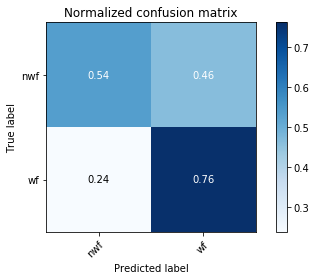

In [23]:
gc.collect()
scaler = pickle.load(open('./Models/scaler_10pct_precip70_cwEQ_ext_new', 'rb'))
feature_cols = wea_features + tl_features + sat_features + fuel_features + precip_cut70
test_sc = build_test(test_df, scaler, feature_cols)
mlp_adam_precip70_cwEQ_ext_new_probs = score_test(test_sc, './Models/mlp_adam_precip70_cwEQ_ext_new.h5')

In [26]:
947/(947+1799865)

0.0005258738835591944

In [24]:
test_sc_df = pd.DataFrame(test_sc)
test_sc_df.columns = feature_cols
test_sc_df.shape

(3884695, 37)

In [25]:
mlp_adam_precip70_cwEQ_ext_new_preds = mlp_adam_precip70_cwEQ_ext_new_probs[:,0]>0.5
features_df = test_sc_df.groupby(mlp_adam_precip70_cwEQ_ext_new_preds).mean().T
features_df.columns = ['nwf', 'wf']
features_df['pct_diff'] = (features_df.wf / features_df.nwf) - 1
features_df.sort_values('pct_diff')

,nwf,wf,pct_diff
sat_faparmask_min,0.000865,0.000000,-1.000000
wea_precip_accum_max_ma30_cut70,0.018915,0.000212,-0.988807
wea_precip_accum_max_ma7_cut70,0.006098,0.000386,-0.936740
wea_precip_accum_max_l1_cut70,0.000916,0.000113,-0.876454
wea_precip_accum_max_cut70,0.023543,0.003214,-0.863498
sat_faparmask_mean,0.065007,0.012320,-0.810482
tl_kv_sort_sum,0.023609,0.008864,-0.624556
sat_faparmask_std,0.168350,0.069543,-0.586914
tl_object_id,0.013208,0.006037,-0.542936
sat_faparval_count,0.152001,0.073198,-0.518438
